In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import os

col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]

for i in range(1, 33):
    col_names.append(f"Sp{i}")

file = 'Steatoda A LD and DD January 18-February 1 2024.txt'

df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
df = df.set_index('Index')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')



month_map = {'Jan': 1, 'Feb': 2}
df['DateM'] = df['DateM'].str[:3].map(month_map)
df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

df.insert(0, 'Day', df['Time'].dt.day.map(day_map)) 

df.to_csv('steatodaA.csv')
display(df)

,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-01-18 13:17:00,1,2,2,15,9,12,10,17,...,6,6,4,0,0,0,0,0,0,0
2,1,2024-01-18 13:18:00,1,0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
3,1,2024-01-18 13:19:00,1,0,0,0,0,1,0,2,...,3,0,20,0,0,0,0,0,0,0
4,1,2024-01-18 13:20:00,1,0,0,0,4,3,0,1,...,0,0,9,0,0,0,0,0,0,0
5,1,2024-01-18 13:21:00,1,0,0,0,3,3,0,0,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20417,15,2024-02-01 17:33:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20418,15,2024-02-01 17:34:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20419,15,2024-02-01 17:35:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def raster_plot(sp, fig):
    for j in range(1, len(df['Day'].unique()) + 1):
        curr_df = df[df['Day']==j]
        #display(curr_df[200:205])
        
        curr_df_avg = curr_df.groupby(curr_df['Time'].dt.hour)[sp].mean()
    
        ax = fig.add_subplot(len(df['Day'].unique()), 1, j)
        ax.set_ylabel(f"Day {j}", rotation="horizontal", va="center", ha="right", fontsize=8)

        
        for k in range(0, len(curr_df) -1):
            start_time = curr_df['Time'].iloc[k]
            end_time = curr_df['Time'].iloc[k + 1]
            if curr_df['Light'].iloc[k] == 1:
                ax.axvspan(start_time.hour + start_time.minute / 60, end_time.hour + end_time.minute / 60, color='yellow', alpha=0.3)

        curr_df_avg.plot.bar(y = [sp], ax=ax)
        
        ax.set_ylim(0, 1)
        ax.legend().remove()
        ax.tick_params(left=False, bottom=False)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlim(-0.5, 23.5)
        ax.set_xlabel("")
        
        if j == 1:
            ax.set_title(sp)
            #ax.text(0.5, 1.5, x, fontsize=12, horizontalalignment='center', transform=ax.transAxes)
            
        if j == len(df["Day"].unique()):
            ax.set_xticks(np.arange(0, 25, 2))
            ax.set_xticklabels(np.arange(0, 25, 2), rotation = 'horizontal', fontsize = 7)
            ax.set_xlabel('Time (hours)')

    if not os.path.exists("Raster_plots"):
            os.makedirs("Raster_plots")
    
    file_path = os.path.join("Raster_plots", f"{sp}_raster_plot.png")
    plt.savefig(file_path)
    plt.close()

In [7]:
for i in range(1, 33):
    x = f"Sp{i}"
    fig = plt.figure(figsize=(4, 6))
    raster_plot(x, fig)

In [44]:
"""

raster plot: LD/DD/LL separation 
user must manually put in day range and LD/LL/DD (may automate second part later)
Parameters that I changed: first day that you would like to select (inclusive), last 

"""

def raster_separate(first_day, last_day, expr_type, sp, fig):
    
    for j in range(first_day, last_day + 1):
        curr_df = df[df['Day']==j]
        
        curr_df_avg = curr_df.groupby(curr_df['Time'].dt.hour)[sp].mean()
    
        ax = fig.add_subplot(last_day + 1, 1, j)
        ax.set_ylabel(f"Day {j}", rotation="horizontal", va="center", ha="right", fontsize=8)

        
        for k in range(0, len(curr_df) -1):
            start_time = curr_df['Time'].iloc[k]
            end_time = curr_df['Time'].iloc[k + 1]
            if curr_df['Light'].iloc[k] == 1:
                ax.axvspan(start_time.hour + start_time.minute / 60, end_time.hour + end_time.minute / 60, color='yellow', alpha=0.3)

        curr_df_avg.plot.bar(y = [sp], ax=ax)
        
        ax.set_ylim(0, 1)
        ax.legend().remove()
        ax.tick_params(left=False, bottom=False)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlim(-0.5, 23.5)
        ax.set_xlabel("")
        
        if j == first_day:
            ax.set_title(sp)
            #ax.text(0.5, 1.5, x, fontsize=12, horizontalalignment='center', transform=ax.transAxes)
            
        if j == last_day:
            ax.set_xticks(np.arange(0, 25, 2))
            ax.set_xticklabels(np.arange(0, 25, 2), rotation = 'horizontal', fontsize = 7)
            ax.set_xlabel('Time (hours)')

    if not os.path.exists("Raster_plots"):
            os.makedirs("Raster_plots")
    
    file_path = os.path.join("Raster_plots", f"{sp}_raster_plot_{expr_type}.png")
    plt.savefig(file_path)
    #plt.close()
    plt.show()

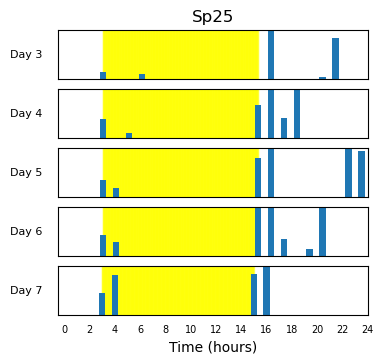

In [46]:
for i in range(25, 26):
    x = f"Sp{i}"
    fig = plt.figure(figsize=(4, 6))
    raster_separate(3, 7, "DD", x, fig)